# Credit Risk Ensemble Techniques

In [85]:
import warnings
warnings.filterwarnings('ignore')

In [86]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

In [87]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

# Read the CSV and Perform Basic Data Cleaning

In [88]:
# Load the data
file_path = Path('Resources/lending_data.csv')
df = pd.read_csv(file_path)

df.head()

,loan_size,interest_rate,homeowner,borrower_income,debt_to_income,num_of_accounts,derogatory_marks,total_debt,loan_status
0,10700.0,7.672,own,52800,0.431818,5,1,22800,low_risk
1,8400.0,6.692,own,43600,0.311927,3,0,13600,low_risk
2,9000.0,6.963,rent,46100,0.349241,3,0,16100,low_risk
3,10700.0,7.664,own,52700,0.430740,5,1,22700,low_risk
4,10800.0,7.698,mortgage,53000,0.433962,5,1,23000,low_risk


In [89]:
df = pd.get_dummies(df, columns=["homeowner"])
df.head()

,loan_size,interest_rate,borrower_income,debt_to_income,num_of_accounts,derogatory_marks,total_debt,loan_status,homeowner_mortgage,homeowner_own,homeowner_rent
0,10700.0,7.672,52800,0.431818,5,1,22800,low_risk,0,1,0
1,8400.0,6.692,43600,0.311927,3,0,13600,low_risk,0,1,0
2,9000.0,6.963,46100,0.349241,3,0,16100,low_risk,0,0,1
3,10700.0,7.664,52700,0.430740,5,1,22700,low_risk,0,1,0
4,10800.0,7.698,53000,0.433962,5,1,23000,low_risk,1,0,0


# Split the Data into Training and Testing

In [90]:
# Create our features
X = df.drop(columns=['loan_status'])
# Create our target
y = df["loan_status"]

In [91]:
X.describe()

,loan_size,interest_rate,borrower_income,debt_to_income,num_of_accounts,derogatory_marks,total_debt,homeowner_mortgage,homeowner_own,homeowner_rent
count,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000
mean,9805.562577,7.292333,49221.949804,0.377318,3.826610,0.392308,19221.949804,0.497472,0.398911,0.103616
std,2093.223153,0.889495,8371.635077,0.081519,1.904426,0.582086,8371.635077,0.499997,0.489678,0.304764
min,5000.000000,5.250000,30000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8700.000000,6.825000,44800.000000,0.330357,3.000000,0.000000,14800.000000,0.000000,0.000000,0.000000
50%,9500.000000,7.172000,48100.000000,0.376299,4.000000,0.000000,18100.000000,0.000000,0.000000,0.000000
75%,10400.000000,7.528000,51400.000000,0.416342,4.000000,1.000000,21400.000000,1.000000,1.000000,0.000000
max,23800.000000,13.235000,105200.000000,0.714829,16.000000,3.000000,75200.000000,1.000000,1.000000,1.000000


In [93]:
# Check the balance of target values
y.value_counts()

low_risk     75036
high_risk     2500
Name: loan_status, dtype: int64

In [94]:
# Split the X and y into X_train, X_test, y_train, y_test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [95]:
# Scaling data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
np.set_printoptions(suppress=True)
print(X_train_scaled)

[[-0.47846852 -0.45947128 -0.45472896 ... -0.99547043  1.2281652
  -0.33997514]
 [-0.47846852 -0.48522635 -0.49042214 ... -0.99547043  1.2281652
  -0.33997514]
 [-0.47846852 -0.46059107 -0.45472896 ... -0.99547043 -0.81422271
   2.94139155]
 ...
 [-0.0502211  -0.06194744 -0.062104   ... -0.99547043  1.2281652
  -0.33997514]
 [-0.954299   -0.95665603 -0.95443346 ... -0.99547043  1.2281652
  -0.33997514]
 [-0.00263805 -0.00931753 -0.01451309 ...  1.00455018 -0.81422271
  -0.33997514]]


# Ensemble Learners

In this section, I will compare two ensemble algorithms to determine which algorithm results in the best performance. I will train a Balanced Random Forest Classifier and an Easy Ensemble classifier. For each algorithm, I will complete the following steps:

1. Train the model using the training data. 
2. Calculate the balanced accuracy score from sklearn.metrics.
3. Print the confusion matrix from sklearn.metrics.
4. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.
5. For the Balanced Random Forest Classifier onely, print the feature importance sorted in descending order (most important feature to least important) along with the feature score

NOTE: I will use a random state of 1 for each algorithm to ensure consistency between tests

### Balanced Random Forest Classifier

In [96]:
# Resample the training data with the BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=1)

rf_model = rf_model.fit(X_train_scaled, y_train)

In [97]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

In [98]:
# Calculate the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test, predictions)

0.9340846819988642

In [106]:
# Create function to display confusion matrix as a dataframe
def cm_to_df(cm, model_title):
    print(f"Confusion Matrix - {model_title}")
    cm_df = pd.DataFrame(cm, index=["High Risk", "Low Risk"], columns=["Predicted High Risk", "Predicted Low Risk"])
    return cm_df

In [107]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predictions)
cm_to_df(cm, "Balanced Random Forest Classifier Confusion Matrix")

Confusion Matrix - Balanced Random Forest Classifier Confusion Matrix


,Predicted High Risk,Predicted Low Risk
High Risk,524,76
Low Risk,97,18687


In [100]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, predictions))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.84      0.87      0.99      0.86      0.93      0.86       600
   low_risk       1.00      0.99      0.87      1.00      0.93      0.88     18784

avg / total       0.99      0.99      0.88      0.99      0.93      0.88     19384



In [101]:
# List the features sorted in descending order by feature importance
important_features = rf_model.feature_importances_

sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.30714967654487896, 'interest_rate'),
 (0.1783989695600131, 'debt_to_income'),
 (0.1606506559579759, 'borrower_income'),
 (0.12776059438664267, 'loan_size'),
 (0.1100162472117901, 'total_debt'),
 (0.06132834124632185, 'num_of_accounts'),
 (0.04327599282166792, 'derogatory_marks'),
 (0.004514346443720409, 'homeowner_own'),
 (0.004507698673801531, 'homeowner_mortgage'),
 (0.0023974771531875836, 'homeowner_rent')]

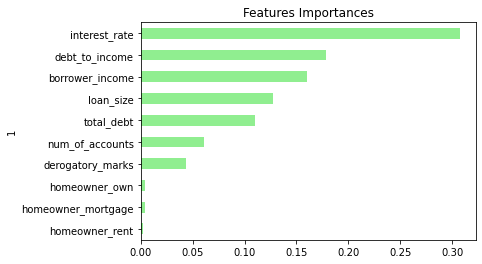

In [102]:
# Visualize the features by their importance to the model
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)


### Easy Ensemble Classifier

In [103]:
# Train the EasyEnsembleClassifier
from imblearn.ensemble import EasyEnsembleClassifier

eec_model = EasyEnsembleClassifier(n_estimators=100, random_state=1)

eec_model = eec_model.fit(X_train_scaled, y_train)


In [104]:
# Calculate the balanced accuracy score
y_pred = eec_model.predict(X_test_scaled)

balanced_accuracy_score(y_test, y_pred)

0.9943057921635434

In [108]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_to_df(cm, "Easy Ensemble Classifier Confusion Matrix")

Confusion Matrix - Easy Ensemble Classifier Confusion Matrix


,Predicted High Risk,Predicted Low Risk
High Risk,597,3
Low Risk,120,18664


In [109]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.83      0.99      0.99      0.91      0.99      0.99       600
   low_risk       1.00      0.99      0.99      1.00      0.99      0.99     18784

avg / total       0.99      0.99      0.99      0.99      0.99      0.99     19384

